In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import pandas as pd
import numpy as np
import argparse
from tqdm import tqdm
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
df = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.01percent_2classes.csv")
df.head(10)

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,std,tot_size,iat,number,radius,covariance,variance,weight,magnitude,benign
0,0.000000,54,TCP,64.00,37,37,0.0,False,True,False,...,0.000000,54.00,82985480.0,9.5,0.000000,0.000000,0.00,141.55,10.392304,False
1,0.000000,54,TCP,64.00,29,29,0.0,True,False,True,...,0.000000,54.00,83345150.0,9.5,0.000000,0.000000,0.00,141.55,10.392304,False
2,0.000000,54,TCP,64.00,0,0,0.0,False,True,False,...,0.000000,54.00,83089680.0,9.5,0.000000,0.000000,0.00,141.55,10.392304,False
3,0.048848,60,TCP,65.91,1,1,0.0,False,True,False,...,2.532528,54.67,83093384.0,9.5,3.586606,46.924720,0.14,141.55,10.464491,False
4,0.555381,883353,UDP,64.00,2870,2870,0.0,False,False,False,...,0.000000,554.00,83784536.0,9.5,0.000000,0.000000,0.00,141.55,33.286633,False
5,0.000000,757,TCP,64.00,0,0,0.0,False,False,False,...,542.677730,941.00,83340504.0,9.5,767.431460,310161.280000,0.95,141.55,44.671032,False
6,0.022671,211,TCP,64.00,4,4,0.0,False,True,False,...,0.000000,54.00,82972390.0,9.5,0.000000,0.000000,0.00,141.55,10.392304,False
7,3.079285,167,TCP,64.59,3,3,0.0,False,True,False,...,0.544870,54.39,83361200.0,9.5,0.773514,4.994529,0.06,141.55,10.405259,False
8,0.003812,65,TCP,63.85,131,131,0.0,False,True,False,...,0.546308,54.12,83089930.0,9.5,0.773505,1.935671,0.16,141.55,10.409713,False
9,14.886163,85793,BBN-RCC-MON,65.87,43,43,0.0,False,False,False,...,483.776820,338.04,83102880.0,9.5,684.409850,666572.100000,0.93,141.55,22.059256,False


In [3]:
def get_feats(categorical : bool=False, important : bool=False) -> list:
    '''
    Returns X and y Tensors, optionally selecting categorical feature 
    (protocol_type) or important features only (from prior analysis)
    '''
    
    # Same no matter which features selected
    y = torch.from_numpy( df['benign'].astype('float32').to_numpy() )
    
    # Features based on importance analysis (https://www.kaggle.com/code/madhavmalhotra/genetic-algorithm-feature-selection)
    if important:
        X = df.loc[:, ["duration", "srate", "drate", "syn_flag_number", "psh_flag_number", "ack_flag_number", "ack_count", "syn_count", "rst_count", "header_length", "https", "ssh", "flow_duration", "avg", "max", "tot_sum", "min", "iat", "magnitude", "radius", "variance"]]
        scaler = StandardScaler()
        X = scaler.fit_transform(X) 
        X = torch.from_numpy( X.astype('float32') )
    
    # All features, including categorical to dummy
    elif categorical:
        X = pd.get_dummies(df['protocol_type'])
        df2 = pd.concat([df.drop(['protocol_type', 'benign'], axis=1), X], axis=1).astype('float32').to_numpy()
        scaler = StandardScaler()
        df2 = scaler.fit_transform(df2)
        X = torch.from_numpy(df2)

    # All numerical features
    else:
        X = df.drop(['protocol_type', 'benign'], axis=1)
        X = torch.from_numpy( X_num.astype('float32').to_numpy() )

    return X,y

In [4]:
# Obtain features (X) and labels (y) with only categorical features
X, _ = get_feats(categorical=False, important=True)

# Get the number of data points and dimensions (features) in X
n_data, n_dims = X.shape

# Set the batch size for training
batch_size = 2048

# Create a PyTorch TensorDataset from the features (X)
data = TensorDataset(X)

# Split the dataset into training and testing sets (80% train, 20% test)
data_tr, data_te = torch.utils.data.random_split(data, [0.8, 0.2])

# Create DataLoader for training set with specified batch size and shuffling the data
load_tr = DataLoader(data_tr, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing set with specified batch size and shuffling the data
load_te = DataLoader(data_te, batch_size=batch_size, shuffle=True)

# Print the shape of the feature tensor X
print(X.shape)
print(X[:5,:5])

torch.Size([466657, 21])
tensor([[-0.1673, -0.0902, -0.0030,  1.9541, -0.3103],
        [-0.1673, -0.0903, -0.0030, -0.5117, -0.3103],
        [-0.1673, -0.0906, -0.0030,  1.9541, -0.3103],
        [-0.0296, -0.0906, -0.0030,  1.9541, -0.3103],
        [-0.1673, -0.0624, -0.0030, -0.5117, -0.3103]])


In [5]:
# Define the SparseAutoencoder class
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, l1_weight=0.01):
        super(SparseAutoencoder, self).__init__()

        # Encoder layer (input_size to hidden_size)
        self.encoder = nn.Linear(input_size, hidden_size)

        # Decoder layer (hidden_size to output_size)
        self.decoder = nn.Linear(hidden_size, input_size)

        # L1 regularization weight
        self.l1_weight = l1_weight

    def forward(self, x):
        '''
        Defining the forward pass, applying layers with the activation function and return the encoding and decoding outputs.
        '''
        # Encoding: Pass input through the encoder with gelu activation
        h = F.gelu(self.encoder(x))

        # Decoding: We simply pass the encoded representation through the decoder without an activation function.
        x_prime = self.decoder(h)

        return x_prime, h

    def l1_regularization(self):
        '''
        Calculating the L1 Regularization for the parameteres and returning its value
        '''
        # Calculate L1 regularization for all parameters
        l1_reg = 0.0
        for param in self.parameters():
            l1_reg += torch.sum(torch.abs(param))

        return self.l1_weight * l1_reg

Epoch [0/5]  Reconstruction Loss: 0.0423  L1 Regularization: 0.0645
Epoch [1/5]  Reconstruction Loss: 0.0699  L1 Regularization: 0.0521
Epoch [2/5]  Reconstruction Loss: 0.0720  L1 Regularization: 0.0443
Epoch [3/5]  Reconstruction Loss: 0.0887  L1 Regularization: 0.0381
Epoch [4/5]  Reconstruction Loss: 0.0769  L1 Regularization: 0.0381


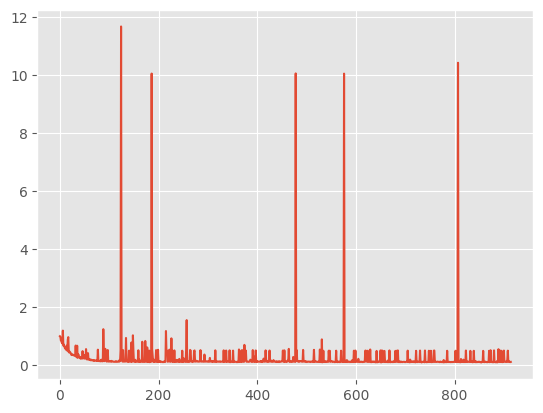

In [6]:
# Instantiate the sparse autoencoder
input_size = 21
hidden_size = 10
l1_weight = 0.001
autoencoder = SparseAutoencoder(input_size, hidden_size, l1_weight=l1_weight)

# Define the loss function: Mean Squared Error Loss
criterion = nn.MSELoss()

# Define the optimizer: Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)

# Training loop
num_epochs = 5

# Create an empty list to store the loss history
loss_history = []

for epoch in range(num_epochs):
    for batch in load_tr:
        # Forward pass
        reconstructions, hidden_activations = autoencoder(batch[0])

        # Calculate reconstruction loss: how well the model reconstructs the input
        reconstruction_loss = criterion(reconstructions, batch[0])

        # Calculate L1 regularization
        l1_reg = autoencoder.l1_regularization()

        # Total loss: combination of reconstruction loss, sparsity penalty, and L1 regularization
        total_loss = reconstruction_loss + l1_reg

        # Backward pass and optimization: update model parameters
        total_loss.backward()  # Compute gradients
        optimizer.step()       # Update parameters using optimizer
        optimizer.zero_grad()  # Clear previous gradients
        
        # Append the total loss to the loss history
        loss_history.append(total_loss.item())
    
    # Print progress every 10 epochs
    print(f'Epoch [{epoch}/{num_epochs}] ',
          f'Reconstruction Loss: {reconstruction_loss.item():.4f} ',
          f'L1 Regularization: {l1_reg.item():.4f}')
    
    # Print the final loss history
plt.plot(loss_history, label='Total Loss')

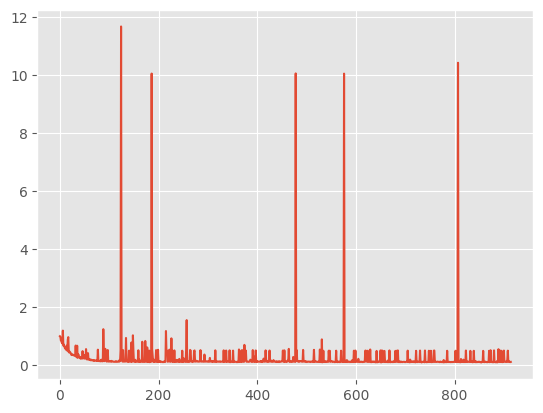

In [7]:
# Print the final loss history
plt.plot(loss_history, label='Total Loss')